# Project: Building a rental price barometer for Madrid using Idealista

### Notebook: Project outline, Exploratory Data Analysis and Modelling
 
Antonio Montilla

Madrid, December 2023

## Introduction and motivation

- Despite a recent economic slowdown prompted by increased policy interest rates globally, housing markets in major advanced economies remain notably tight. Nominal housing prices have sustained positive growth in 2023, as reported by the Bank of International Settlements (3.7% YoY in Spain and 2.4% in the US during the first half of the year). 
- Unfavorable borrowing costs, stricter lending standards, and overall housing supply constraints have compelled many potential buyers to opt for renting, intensifying demand and subsequently driving up rental prices. Notably, cities like Madrid experienced a record-high average rental price in November, marking a 12% increase from the end of 2022, according to rental portal Idealista.
- In response to this dynamic market, our project aims to address the need for timely and precise information on rental conditions. Monthly publications of rental price data and the challenge of obtaining daily aggregate information from various real estate portals underscore the importance of a solution. 
- Our project introduces a rental price barometer utilizing listings from the Idealista portal. Specifically, we develop a predictive model for rental prices in Madrid based on the portal's information at the beginning of December 2023, adding up to 4,500 listed properties. While the model lacks real-time updates due to data limitations, potential development in that direction is acknowledged.
- The trained model is incorporated into a rental barometer interface, engaging users in providing property features for a model-based prediction aligned with market prices as of December 2023. The interface provides users a predicted rental price range, statistical insights (average, minimum, and maximum) on current available properties matching the criteria, and a curated list of up to 5 potential listings. Additionally, users can access socio-economic information for the searched district sourced from Madrid’s government open data portal, featuring details on parks, health facilities, and resident demographics.
- While the price barometer aspires to be a go-to resource for gauging rental prices in Madrid based on Idealista data, it acknowledges its limitations. The model's focus on newly available properties within a single portal renders it non-representative of the city's average rental price. The broader landscape, including existing tenants with government-capped rental contracts, is excluded. Moerever, the barometer lacks the ability to connect with real-time data, making its information valid only for December 2023. Future iterations may address these limitations for a more comprehensive understanding of Madrid's rental market.

## Objectives

1. **Data Extraction.** Define and implement a robust process for extracting rental price listings using the Idealista API.
2. **Exploratory Data Analysis (EDA).** Conduct in-depth exploratory data analysis using statistical and visual techniques to unveil correlations, trends, and anomalies. Implement feature engineering, data cleaning, and wrangling techniques to prepare the data for modeling.
3. **Machine Learning Regression Modelling.** Construct a regression model using machine learning techniques to predict rental prices based on selected features. Compare and evaluate various regression models through cross-validation and hyperparameter search to determine the most suitable algorithm and model specification for the dataset.
4. **Model Deployment.** Develop a user interface for the rental price barometer app, integrating the selected regression model. Implement filters to allow users to select listings from the database, with the beta version serving as a prototype for potential future development.
5. **Complementary Database Integration.** Enhance the rental price barometer by incorporating socio-economic features of each district (demographics, median income, park availability) as optional information provided to users upon request.

## Data extraction

- The data for this project was obtained by the Idealista API, using a API-key and passwords kindly provided by the web portal for academic and research purposes.
- The process to obtain the data is explained and performed in a separate notebook (Rental_price_barometer1_data_extraction.ipynb) saved in this repository.
- The data obtained for this project consists of 4,500 listed properties in Idealista for rent in the city of Madrid. The main steps for obtaining the data were:
    * Building a function to URL encode API-key and password provided by Idealista, following the criteria set by the API documentation.
    * Setting a function to connect with the API and make requests for listed properties with the given specifications: rental properties in the city of Madrid, sorted by distance from Puerta del Sol geographical position and with a ratio limit of 10 km.
    * Transforming each response from Json format into a dataframe.
    * Producing a function to make requests for multiple pages, given that each response has a limit of 50 listings. This step allowed to store each response as separate csv file and combined all results into a final dataframe, which would be imported for analysis and modelling in this notebook.
- Due to data privacy, sensible information (API-key, csv files, information for each listing) is stored separately  and not published in this repository.
- Finally, for objective 5, socio-economic and demographic data is obtained from Madrid regional government open portal (see https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=71359583a773a510VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default).

## Importing libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import random as rnd
from pandas import read_csv
from scipy.stats import ttest_1samp
import time
import json
import math
import pickle

# Data visualization
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats 
import matplotlib.pyplot as plt

#Data transformation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Machine learning
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression


## Importing the database and preliminary exploratory analysis

In [2]:
data = pd.read_csv('data_1_90.csv')

In [3]:
data

,propertyCode,thumbnail,externalReference,numPhotos,price,propertyType,operation,size,rooms,bathrooms,...,hasPlan,has3DTour,has360,hasLift,hasStaging,luxuryType,villaType,superTopHighlight,topNewDevelopment,topPlus
0,103241997,https://img3.idealista.com/blur/WEB_LISTING/90...,ACCM,21,1350.0,flat,rent,55.0,1,2,...,True,False,False,True,False,False,False,False,False,False
1,101227123,https://img3.idealista.com/blur/WEB_LISTING/0/...,3d26340f0da112d7aafd,15,1743.0,studio,rent,25.0,0,1,...,True,False,False,True,False,False,False,False,False,False
2,458306,https://img3.idealista.com/blur/WEB_LISTING/0/...,NaN,24,1595.0,flat,rent,98.0,2,2,...,False,False,False,True,False,False,False,False,False,False
3,99586539,https://img3.idealista.com/blur/WEB_LISTING/0/...,2392,22,2400.0,flat,rent,57.0,1,1,...,False,False,False,True,False,False,False,False,False,False
4,102075463,https://img3.idealista.com/blur/WEB_LISTING/0/...,120413,23,1488.0,flat,rent,42.0,1,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,100627014,https://img3.idealista.com/blur/WEB_LISTING/0/...,Skyline VI,13,2160.0,flat,rent,66.0,2,2,...,False,False,False,True,False,False,False,False,False,False
4496,100930829,https://img3.idealista.com/blur/WEB_LISTING/0/...,Skyline V,16,2160.0,flat,rent,55.0,1,1,...,False,False,False,True,False,False,False,False,False,False
4497,100097037,https://img3.idealista.com/blur/WEB_LISTING/0/...,Skyline I,11,2700.0,flat,rent,85.0,2,2,...,False,False,False,True,False,False,False,False,False,False
4498,100931418,https://img3.idealista.com/blur/WEB_LISTING/0/...,Skyline VIII,13,2160.0,flat,rent,50.0,1,1,...,False,False,False,True,False,False,False,False,False,False


In [4]:
data.shape

(4500, 40)

In [5]:
data.columns

Index(['propertyCode', 'thumbnail', 'externalReference', 'numPhotos', 'price',
       'propertyType', 'operation', 'size', 'rooms', 'bathrooms', 'address',
       'province', 'municipality', 'district', 'country', 'latitude',
       'longitude', 'showAddress', 'url', 'distance', 'description',
       'hasVideo', 'status', 'newDevelopment', 'parkingSpace', 'priceByArea',
       'typology', 'subTypology', 'subtitle', 'title', 'hasPlan', 'has3DTour',
       'has360', 'hasLift', 'hasStaging', 'luxuryType', 'villaType',
       'superTopHighlight', 'topNewDevelopment', 'topPlus'],
      dtype='object')

In [6]:
data.describe(include= "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
propertyCode,4500.0,NaN,NaN,NaN,97826537.839111,14815240.394326,458306.0,99167693.75,102594824.0,103241428.5,103406517.0
thumbnail,4474,4457,https://img3.idealista.com/blur/WEB_LISTING/0/...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
externalReference,3433,3395,CIUDAD RODRIGO 2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numPhotos,4500.0,NaN,NaN,NaN,25.339333,13.186969,0.0,16.0,24.0,31.0,116.0
price,4500.0,NaN,NaN,NaN,2676.896,1982.276787,600.0,1450.0,2100.0,3200.0,20000.0
propertyType,4500,5,flat,3744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,4500,1,rent,4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,4500.0,NaN,NaN,NaN,104.872711,76.913269,17.0,55.0,80.0,130.0,1400.0
rooms,4500.0,NaN,NaN,NaN,2.043778,1.209025,0.0,1.0,2.0,3.0,10.0
bathrooms,4500.0,NaN,NaN,NaN,1.765556,1.009585,1.0,1.0,1.0,2.0,11.0


**Preliminary observations:**
- The dataset contains 4,500 rows of rental listings in the city of Madrid, sorted by distance from city center.
- There are 40 features available:
    * **Price**: numeric column containing the asking monthly rent price for each property, the target variable.
    * **propertyCode**: a numeric column with the identifier of each listing. Will be dropping this column.
    * **thumbnail**: string column with the url image posted in each listing. Will be dropping this column.
    * **externalReference**: string column unique for each listing. Will be dropping this column.
    * **numPhotos**: numerical column indicating the number of pictures available in each listing. Will be dropping this column.
    * **propertyType**: categorical column indicating the property type (e.g. flat, studio or penthouse).
    * **operation**: a column that identifies each listing as a rental property (instead of selling). This column will be dropped.
    * **size**: numeric column indicating the size of the property in sqr mts.
    * **rooms**: numeric column indicating the number of rooms available in the property.
    * **bathrooms**: numeric column indicating the number of bathrooms available in the property.
    * **address**: categorical column with string indicating the address, which could be exact or indicating only district.
    * **province**: column denoting that the rental is located in Madrid. This column will be dropped.
    * **municipality**: same as province (Madrid). This column will also be dropped.
    * **district**: column referring to the district (e.g. centro, Arganzuela).
    * **country**: column denoting that the rental is in Spain. This column will be dropped.
    * **latitude**: map latitude coordinate, which is only exact if listed (usually it is given for the neighbourhood). For location, this project will be using district and neighbourhood. This column will therefore be dropped.
    * **longitude**: similar to latitude, this column will be dropped.
    * **showAddress**: a boolean column noting if the listing shows exact address. Will be dropping this column.
    * **url**: column with web url direction of each listing. Will be dropping this column.
    * **distance**: numeric column indicating approximate distance from city center (Puerta del Sol).
    * **description**: categorical column with string with information published in each listing. It could be interesting to study if any relevant information could be extracted from this description, e.g. if listing is for permanent of temporal contract.
    * **hasVideo**: boolean column indicating if the listing has a video. Will be dropping this column.
    * **status**: categorical column indicating the status of each listing, but only with very limited unique values (good). Will be dropping this column.
    * **newDevelopment**: boolean column indicating if the listing is in a new development or not.
    * **parkingSpace**: boolean column indicating if the listing has parking.
    * **priceByArea**: numeric column indicating average price/mt2 for each area. I will be dropping this column as it contains very similar information as the target column.
    * **typology**: categorical column indicating the type of property (e.g. flat). I will drop this column as the information is already available in other columns, such as propertyType.
    * **subTypology**: categorical column indicating more information on the type of property (e.g. studio). Will also be dropping this column.
    * **subtitle**: categorical column indicating the neighbourhood.
    * **title**: categorical column with string of the title of each listing. Could potentially be useful to extract other information.
    * **hasPlan**: boolean column indicating if the listing has an architecture plan attached. Will be dropping this column.
    * **has3DTour**: boolean column indicating if the listing has a 3DTour attached. Will be dropping this column.
    * **has360**: boolean column indiating if the listing has a 360 virtual tour attached. Will be dropping this column.
    * **hasLift**: boolean column indicating in the listing has lift available in the building.
    * **hasStaging**: boolean column indicating if the listing has Staging. Will be dropping this column.
    * **luxuryType**: boolean column indicating if the listing has been tagged as luxury.
    * **villaType**: boolean column indicating if the listing has been tagged as a villa.
    * **superTopHighlight**: boolean column indicating if the listing has been tagged as TopHighlight.
    * **topNewDevelopment**: boolean column indicating if the listing has been tagged as Top New Development.
    * **topPlus**: boolean column indicating if the listing has been tagged as topPlus.

In [7]:
#Initial columns to be dropped from the database for modelling
cols_drop = ['propertyCode', 'thumbnail', 'externalReference', 'numPhotos', 'operation', 'province', 'municipality', 'country', 'latitude', 'longitude', 'showAddress', 'url', 'hasVideo', 'status', 'hasPlan', 'has3DTour', 'priceByArea', 'typology', 'subTypology', 'has360', 'hasStaging']

In [8]:
#will drop column in a copy of the df, which I will use for further steps
data2 = data.drop(cols_drop, axis = 1)
data2.shape

(4500, 19)

## Data Cleaning & Exploratory Data Analysis

#### Checking for duplicates

In [9]:
display(data2.duplicated().sum())
data2 = data2.drop_duplicates()
display(data2.shape)

10

(4490, 19)

- 10 rows were identified as duplicates (properties listed by some agencies more than once). We dropped these columns from the dataframe, resulting in an adjusted shape of 4,490 rows and 19 columns.

#### Checking for NaNs or nulls values

In [10]:
data2.isnull().sum()

price                0
propertyType         0
size                 0
rooms                0
bathrooms            0
address              0
district             0
distance             0
description          8
newDevelopment       0
parkingSpace         0
subtitle             0
title                0
hasLift              0
luxuryType           0
villaType            0
superTopHighlight    0
topNewDevelopment    0
topPlus              0
dtype: int64

In [11]:
total = data2.isnull().sum().sort_values(ascending = False) #adding NaNs by column
percentage = (data2.isnull().sum()/data2.isnull().count()*100).sort_values(ascending = False) #% of total
missing_data  = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage']) #df para explorar
missing_data

,Total,Percentage
description,8,0.178174
price,0,0.000000
parkingSpace,0,0.000000
topNewDevelopment,0,0.000000
superTopHighlight,0,0.000000
villaType,0,0.000000
luxuryType,0,0.000000
hasLift,0,0.000000
title,0,0.000000
subtitle,0,0.000000


In [12]:
#filling NaN description with a string 'not available':
data2['description'] = data2['description'].fillna('not available')

In [13]:
#checking if there are none NaNs now:
data2.isnull().sum()

price                0
propertyType         0
size                 0
rooms                0
bathrooms            0
address              0
district             0
distance             0
description          0
newDevelopment       0
parkingSpace         0
subtitle             0
title                0
hasLift              0
luxuryType           0
villaType            0
superTopHighlight    0
topNewDevelopment    0
topPlus              0
dtype: int64

In [14]:
#checking data types before splitting
data2.dtypes

price                float64
propertyType          object
size                 float64
rooms                  int64
bathrooms              int64
address               object
district              object
distance               int64
description           object
newDevelopment          bool
parkingSpace            bool
subtitle              object
title                 object
hasLift                 bool
luxuryType              bool
villaType               bool
superTopHighlight       bool
topNewDevelopment       bool
topPlus                 bool
dtype: object

In [15]:
#will transform boolean columns into numeric (1, 0) instead:
bolean_col = ['newDevelopment', 'parkingSpace', 'luxuryType', 'villaType', 'superTopHighlight', 'topNewDevelopment', 'topPlus', 'hasLift']
for col in bolean_col:
    data2[col] = data2[col].astype(int)
data2.dtypes

price                float64
propertyType          object
size                 float64
rooms                  int64
bathrooms              int64
address               object
district              object
distance               int64
description           object
newDevelopment         int64
parkingSpace           int64
subtitle              object
title                 object
hasLift                int64
luxuryType             int64
villaType              int64
superTopHighlight      int64
topNewDevelopment      int64
topPlus                int64
dtype: object

In [16]:
#checking for one ex boolean column
data2['luxuryType'].value_counts()

0    4119
1     371
Name: luxuryType, dtype: int64

### Data wrangling: Splitting the data into Categorical and Numerical

In [17]:
#splitting into categorical and numerical
numerical_df = data2.select_dtypes(np.number)
numerical_df

,price,size,rooms,bathrooms,distance,newDevelopment,parkingSpace,hasLift,luxuryType,villaType,superTopHighlight,topNewDevelopment,topPlus
0,1350.0,55.0,1,2,28,0,0,1,0,0,0,0,0
1,1743.0,25.0,0,1,38,0,0,1,0,0,0,0,0
2,1595.0,98.0,2,2,81,0,0,1,0,0,0,0,0
3,2400.0,57.0,1,1,82,0,0,1,0,0,0,0,0
4,1488.0,42.0,1,1,84,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2160.0,66.0,2,2,5692,0,0,1,0,0,0,0,0
4496,2160.0,55.0,1,1,5692,0,1,1,0,0,0,0,0
4497,2700.0,85.0,2,2,5692,0,0,1,0,0,0,0,0
4498,2160.0,50.0,1,1,5692,0,0,1,0,0,0,0,0


In [18]:
categorical_df = data2.select_dtypes(object)
categorical_df

,propertyType,address,district,description,subtitle,title
0,flat,"Madera, 7",Centro,"TuKsa Madrid Inmobiliara, ofrece en alquiler v...","Sol, Madrid","Piso en Madera, 7"
1,studio,Calle de Postas,Centro,UBK-573819 (Disponible 1-11 meses) - Sin posib...,"Sol, Madrid",Estudio en Calle de Postas
2,flat,Calle Atocha,Centro,*OJO DISPONIBLE A PARTIR 16 DE MAYO 2.024* Dir...,"Sol, Madrid",Piso en Calle Atocha
3,flat,Calle de la Abada,Centro,ALQUILER DE 1 A 12 MESES GASTOS INCLUIDOS Do...,"Sol, Madrid",Piso en Calle de la Abada
4,flat,barrio Sol,Centro,[ESP] DISPONIBLE EN: Enero. Reserve en línea ...,"Sol, Madrid",Piso
...,...,...,...,...,...,...
4495,flat,"Paseo de la Dirección, 161",Tetuán,Piso de Home Club disponible por alquiler por ...,"Valdeacederas, Madrid","Piso en Paseo de la Dirección, 161"
4496,flat,"Paseo de la Dirección, 161",Tetuán,Piso de Home Club disponible por alquiler por ...,"Valdeacederas, Madrid","Piso en Paseo de la Dirección, 161"
4497,flat,"Paseo de la Dirección, 161",Tetuán,"*Piso de 2 dormitorios con parking, ascensor, ...","Valdeacederas, Madrid","Piso en Paseo de la Dirección, 161"
4498,flat,"Paseo de la Dirección, 161",Tetuán,Piso de Home Club disponible por alquiler por ...,"Valdeacederas, Madrid","Piso en Paseo de la Dirección, 161"


#### Data Wrangling: numerical_df

In [19]:
numerical_df.columns

Index(['price', 'size', 'rooms', 'bathrooms', 'distance', 'newDevelopment',
       'parkingSpace', 'hasLift', 'luxuryType', 'villaType',
       'superTopHighlight', 'topNewDevelopment', 'topPlus'],
      dtype='object')

In [20]:
numerical_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4490.0,2677.677506,1984.062164,600.0,1450.00,2100.0,3200.0,20000.0
size,4490.0,104.972428,76.962947,17.0,55.00,80.0,130.0,1400.0
rooms,4490.0,2.045657,1.209567,0.0,1.00,2.0,3.0,10.0
bathrooms,4490.0,1.767038,1.010120,1.0,1.00,1.0,2.0,11.0
distance,4490.0,2421.721826,1412.324717,28.0,1251.25,2261.5,3318.0,5692.0
newDevelopment,4490.0,0.004677,0.068237,0.0,0.00,0.0,0.0,1.0
parkingSpace,4490.0,0.178842,0.383263,0.0,0.00,0.0,0.0,1.0
hasLift,4490.0,0.836303,0.370042,0.0,1.00,1.0,1.0,1.0
luxuryType,4490.0,0.082628,0.275350,0.0,0.00,0.0,0.0,1.0
villaType,4490.0,0.000445,0.021103,0.0,0.00,0.0,0.0,1.0


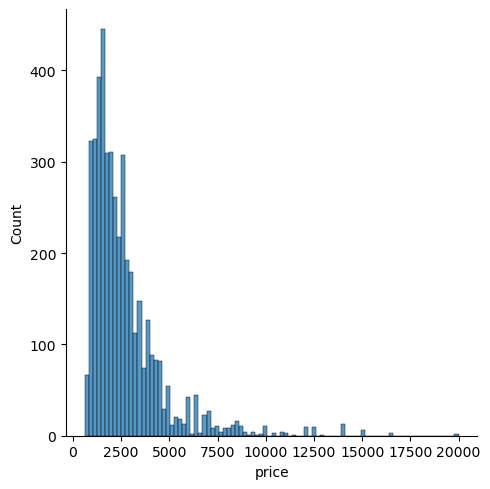

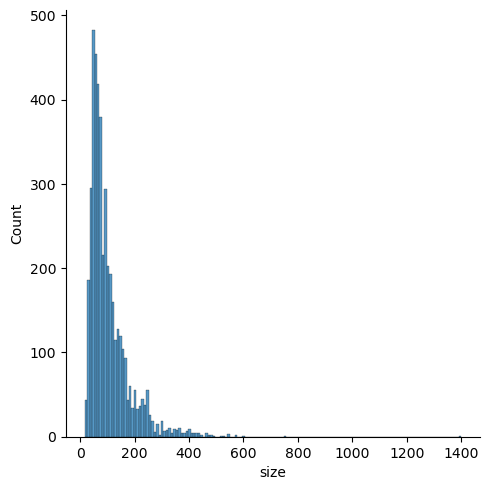

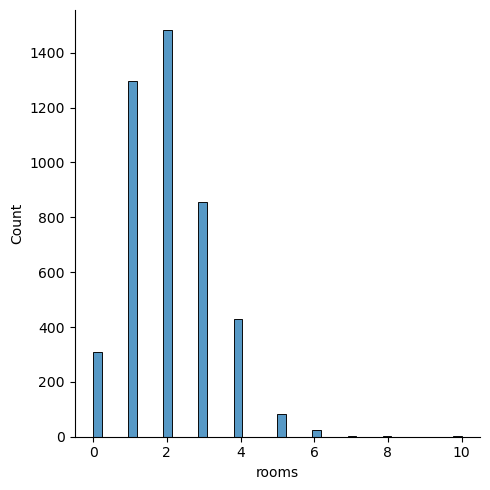

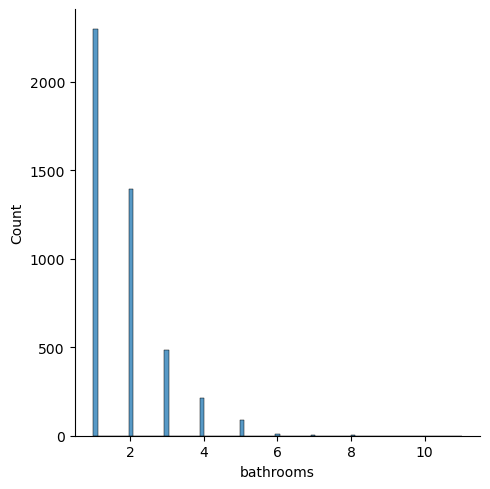

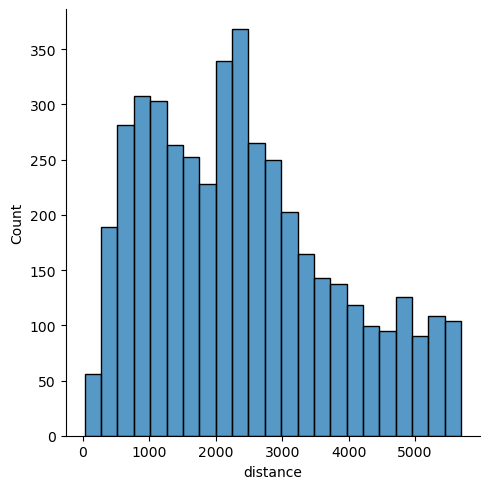

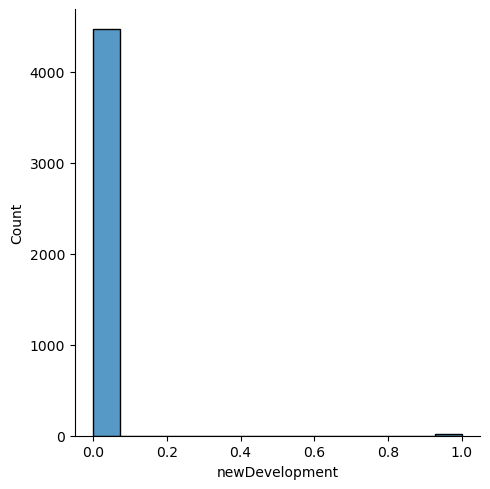

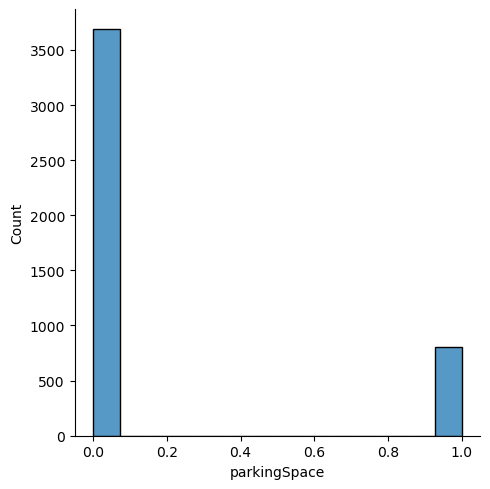

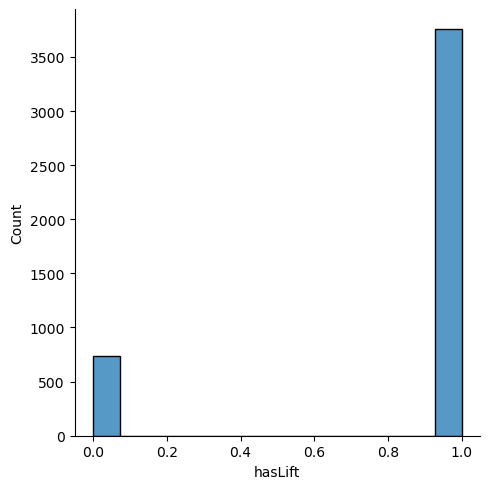

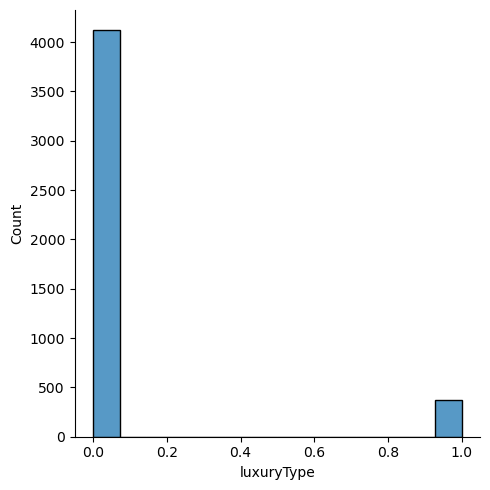

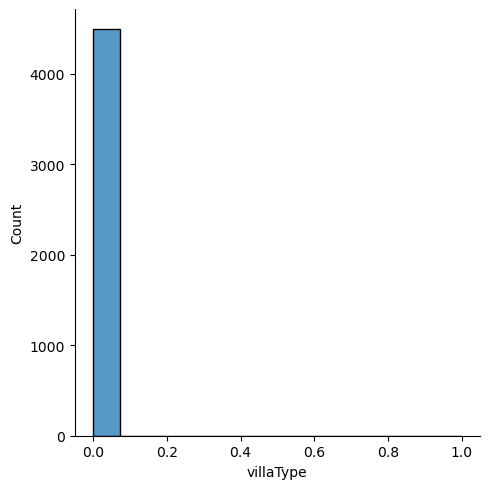

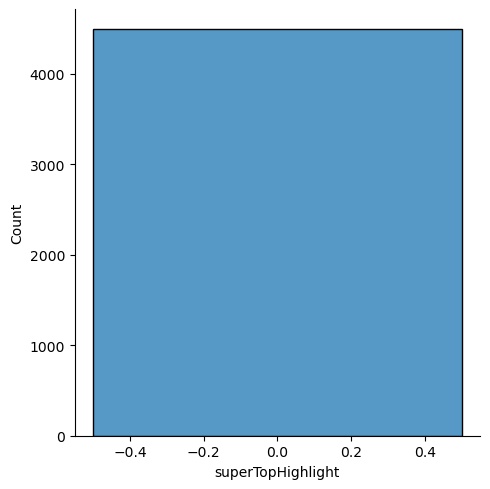

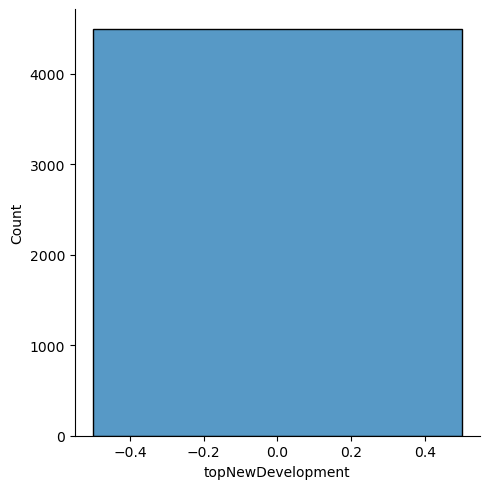

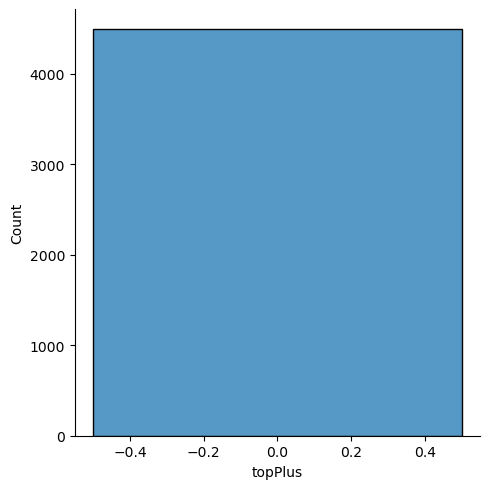

In [21]:
#looking at the histogram for each numerical column:
for c in numerical_df.columns:
    sns.displot(numerical_df[c])
    plt.show()

- From the histograms, I can observe that the column 'price' is a continuous variable that resembles a normal distribution, although slightly tilted to the left and with some outliers on the right (properties with unusual high prices, up to 20,000 euros per month). The average rental price is about 2,680 euros/month, with a st. deviation of close to 2,000 euros. The minimum asking price currently is 600 euros/month.
- For other columns:
    * 'size' is a continuous variable, with a distribution that also resembles a normal distribution with a concentration around the value 100 mts, the mean.
    * 'distance' is a continuos variable that also resembles a normal distribution. It ranges from 0 to 5,600, which corresponds to the distance in mts of each listed property to Madrid's city center.
    * All other columns ('rooms', 'bathrooms', 'newDevelopment', 'parkingSpace', 'luxuryType', 'hasLift', villaType', 'superTopHighlight', 'topNewDevelopment', 'topPlus') are discrete variables, for which I will create bar charts to look at each category more easily.

2     1482
1     1298
3      855
4      428
0      308
5       84
6       26
8        4
7        4
10       1
Name: rooms, dtype: int64

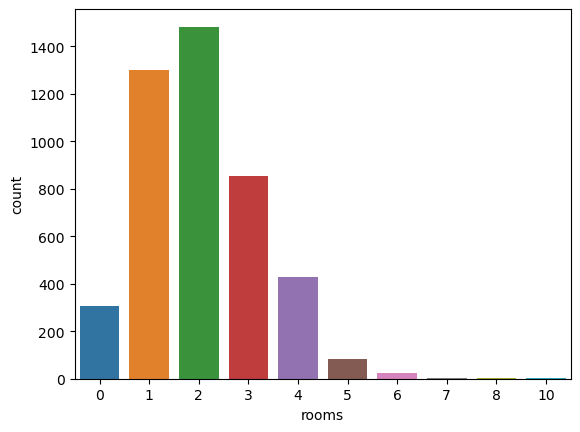

In [22]:
#rooms: number of rooms in each listing
display(numerical_df['rooms'].value_counts(dropna = False))
sns.countplot(x='rooms', data=numerical_df)
plt.show()

- The number of rooms ranges from 0 (studios) to 10, although the latter corresponds to only 1 property. I will not be making any changes to this column. This is one of the key features to be included in the model and in the rental barometer.


1     2296
2     1394
3      484
4      212
5       87
6       10
7        4
8        2
11       1
Name: bathrooms, dtype: int64

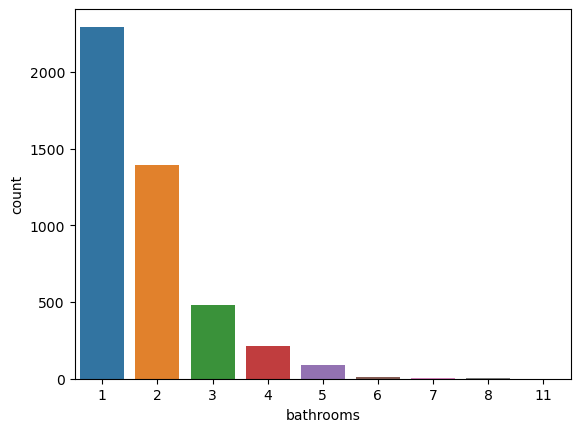

In [23]:
#bathrooms: number of bathrooms in each listing
display(numerical_df['bathrooms'].value_counts(dropna = False))
sns.countplot(x='bathrooms', data=numerical_df)
plt.show()

- The number of bathrooms ranges from 1 to 11, with 1 being the most frequent. I will not be making any changes to this column.

1    3755
0     735
Name: hasLift, dtype: int64

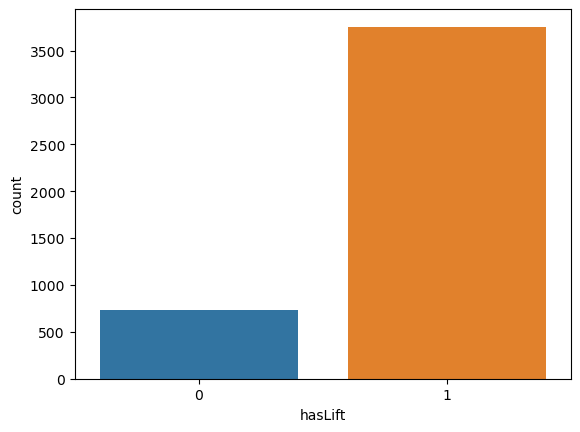

In [24]:
#hasLift: 1 if property has a lift, 0 otherwise
display(numerical_df['hasLift'].value_counts(dropna = False))
sns.countplot(x='hasLift', data=numerical_df)
plt.show()

- Out of the 4,490 listed properties, 3,755 include a lift, that is near 85% of the total. Will leave this column unchanged. 

0    4469
1      21
Name: newDevelopment, dtype: int64

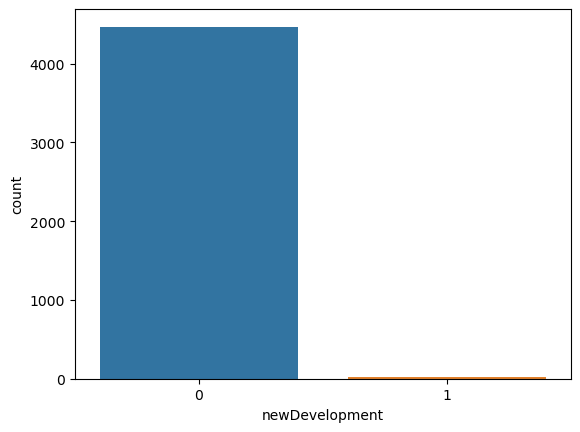

In [25]:
#newDevelopment: 1 if property is in new developmet, 0 otherwise
display(numerical_df['newDevelopment'].value_counts(dropna = False))
sns.countplot(x='newDevelopment', data=numerical_df)
plt.show()

- Only a very limited amount of properties (21 out of 4,490) are identified as new development.
- Due to lack of variance, I will be dropping this column for the modelling section later on.

0    3687
1     803
Name: parkingSpace, dtype: int64

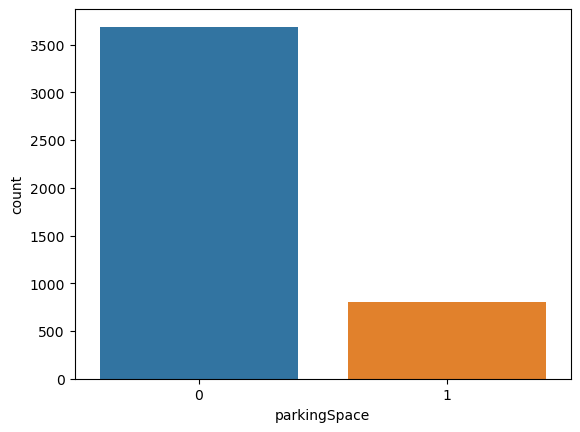

In [26]:
#parkingSpace: 1 if property has parking available, 0 otherwise
display(numerical_df['parkingSpace'].value_counts(dropna = False))
sns.countplot(x='parkingSpace', data=numerical_df)
plt.show()

- As expected, more than 80% of listed properties do not have parking space. 
- While unlikely to make a significant contribution to the model, I will leave this column as it is, as this is one of the key features some users tend to care about when selecting a property.

0    4119
1     371
Name: luxuryType, dtype: int64

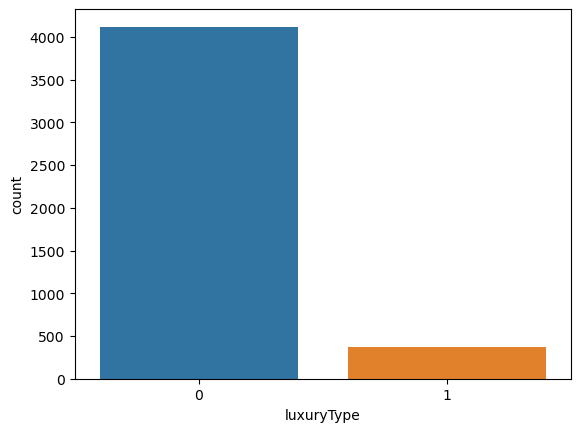

In [27]:
#luxuryType: 1 if property has been tagged as luxury, 0 otherwise
display(numerical_df['luxuryType'].value_counts(dropna = False))
sns.countplot(x='luxuryType', data=numerical_df)
plt.show()

- There were only 371 properties tagged as luxury. Will leave for now but this column could potentially be dropped later on.

0    4488
1       2
Name: villaType, dtype: int64

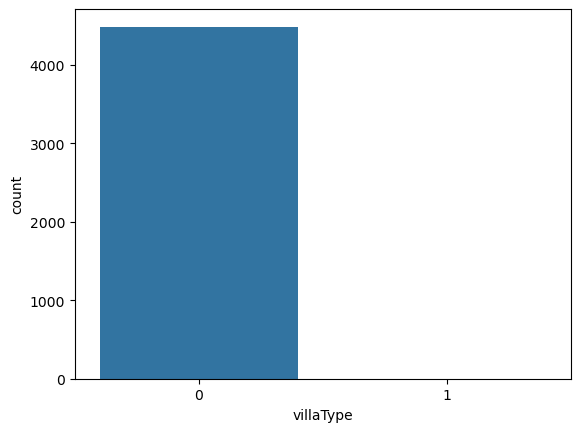

In [28]:
#villaType: 1 if property has been tagged as a villa, 0 otherwise
display(numerical_df['villaType'].value_counts(dropna = False))
sns.countplot(x='villaType', data=numerical_df)
plt.show()

- As expected, there were almost no properties listed as a villa in Madrid main urban area. Will be dropping this column later on.

0    4490
Name: superTopHighlight, dtype: int64

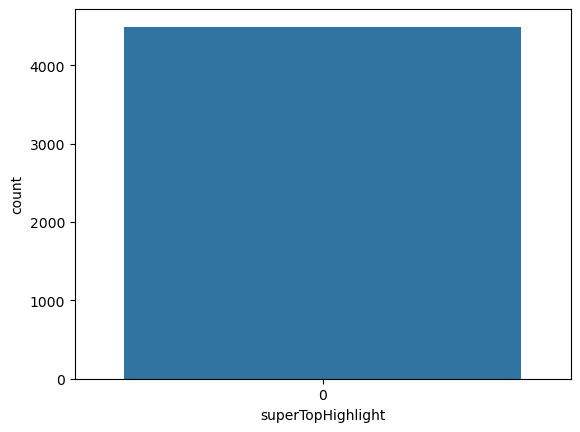

In [29]:
#superTopHighlight: 1 if property has been tagged as superTopHighlight, 0 otherwise
display(numerical_df['superTopHighlight'].value_counts(dropna = False))
sns.countplot(x='superTopHighlight', data=numerical_df)
plt.show()

- There were also no properties listed as superTopHighlight. Will be dropping this column later on.

0    4490
Name: topNewDevelopment, dtype: int64

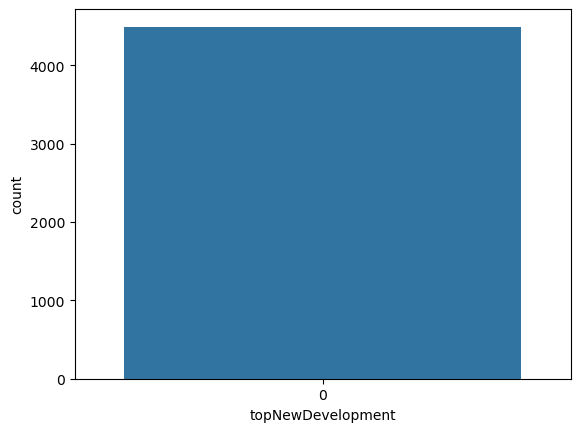

In [30]:
#topNewDevelopment: 1 if property has been tagged as a topNewDevelopment, 0 otherwise
display(numerical_df['topNewDevelopment'].value_counts(dropna = False))
sns.countplot(x='topNewDevelopment', data=numerical_df)
plt.show()

- Simlarly, no properties were listed as topNewDevelopment. Will add this column to the dropping list.

0    4490
Name: topPlus, dtype: int64

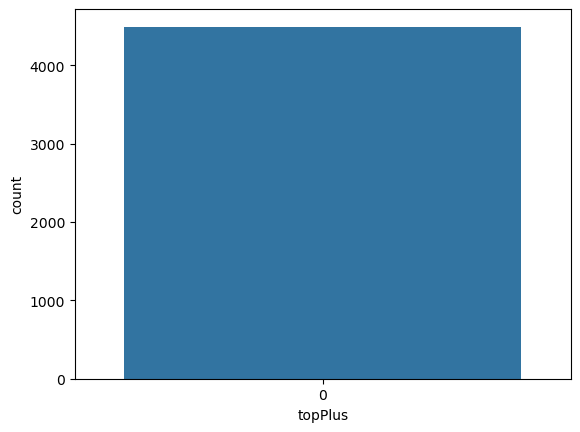

In [31]:
#topPlus: 1 if property has been tagged as topPlus, 0 otherwise
display(numerical_df['topPlus'].value_counts(dropna = False))
sns.countplot(x='topPlus', data=numerical_df)
plt.show()

- Same as other two columns, there are no observations listed as topPlus. Will also drop this column.

In [32]:
#dropping columns
cols_num_drop = ['newDevelopment', 'villaType', 'superTopHighlight', 'topNewDevelopment', 'topPlus']
numerical_df = numerical_df.drop(cols_num_drop, axis = 1)

In [33]:
numerical_df

,price,size,rooms,bathrooms,distance,parkingSpace,hasLift,luxuryType
0,1350.0,55.0,1,2,28,0,1,0
1,1743.0,25.0,0,1,38,0,1,0
2,1595.0,98.0,2,2,81,0,1,0
3,2400.0,57.0,1,1,82,0,1,0
4,1488.0,42.0,1,1,84,0,0,0
...,...,...,...,...,...,...,...,...
4495,2160.0,66.0,2,2,5692,0,1,0
4496,2160.0,55.0,1,1,5692,1,1,0
4497,2700.0,85.0,2,2,5692,0,1,0
4498,2160.0,50.0,1,1,5692,0,1,0


#### Data Wrangling: categorical_df

In [34]:
categorical_df.columns

Index(['propertyType', 'address', 'district', 'description', 'subtitle',
       'title'],
      dtype='object')

flat         3734
penthouse     308
studio        289
duplex        130
chalet         29
Name: propertyType, dtype: int64

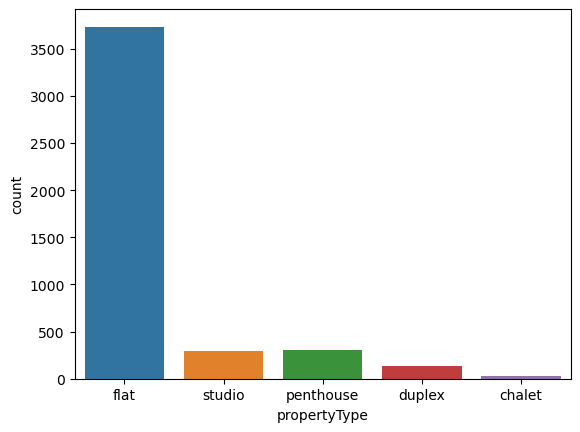

In [35]:
#propertyType
display(categorical_df['propertyType'].value_counts(dropna = False))
sns.countplot(x='propertyType', data=categorical_df)
plt.show()

- Flats are the most frequent property type.
- To reduce columns, I will be aggregating categories "studio" and "duplex" into "others". And will add "chalet" to "penthouse", as these are likely luxury properties.

In [36]:
#creating "others"
categorical_df['propertyType'] = categorical_df['propertyType'].replace(['studio', 'duplex'], 'other')
#replacing "chalet" for "penthouse"
categorical_df['propertyType'] = categorical_df['propertyType'].replace('chalet', 'penthouse')
display(categorical_df['propertyType'].value_counts(dropna = False))

flat         3734
other         419
penthouse     337
Name: propertyType, dtype: int64

Centro                 1143
Barrio de Salamanca    1019
Chamberí                635
Chamartín               402
Tetuán                  320
Retiro                  307
Moncloa                 160
Arganzuela              153
Ciudad Lineal           101
Latina                   70
Carabanchel              65
Puente de Vallecas       54
Usera                    51
Moratalaz                10
Name: district, dtype: int64

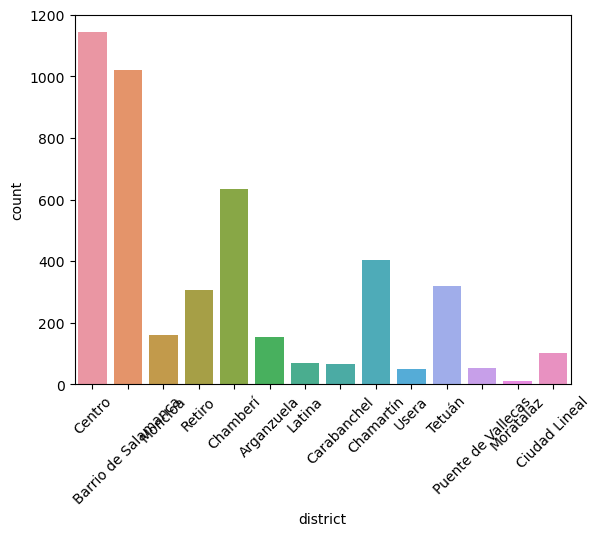

In [37]:
#district
display(categorical_df['district'].value_counts(dropna = False))
sns.countplot(x='district', data=categorical_df)
plt.xticks(rotation=45)
plt.show()

- Listed properties are split in 14 districts, with "Centro" the most relevant (as expected, given that properties were requested based on distance from Puerta del Sol).
- Will explore the relationship between average rental price per district. For doing so, I will calculate a selected dataframe from data2 with: (i) district and (ii) price_per_mt2 (calculated as price divided by size).

In [38]:
data2['price_per_size'] = data2['price']/data2['size']

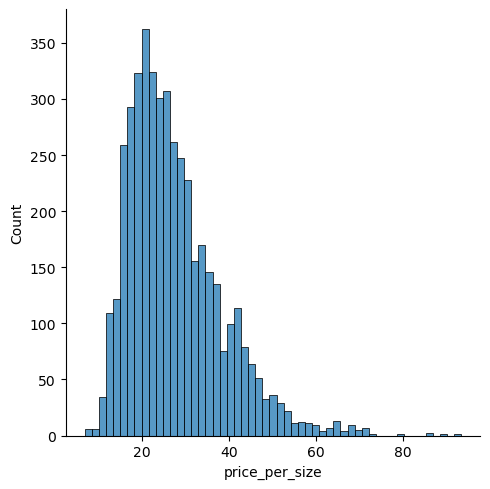

In [39]:
#looking at histogram
sns.displot(data2['price_per_size'])
plt.show()

In [40]:
#using groupby to show average price per district
average_prices_dist = data2.groupby('district')['price_per_size'].mean().reset_index()
average_prices_dist

,district,price_per_size
0,Arganzuela,22.164585
1,Barrio de Salamanca,30.944847
2,Carabanchel,21.078364
3,Centro,29.603883
4,Chamartín,24.445991
5,Chamberí,27.870775
6,Ciudad Lineal,19.444338
7,Latina,20.268195
8,Moncloa,24.977761
9,Moratalaz,13.621769


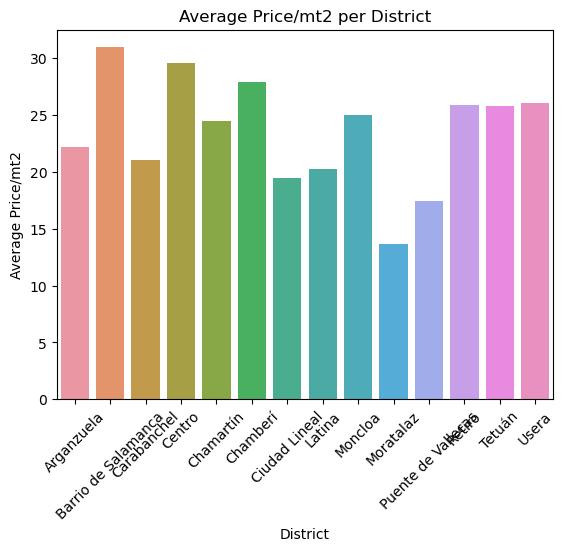

In [41]:
#plotting the average_price
sns.barplot(x='district', y='price_per_size', data=average_prices_dist)
plt.title('Average Price/mt2 per District')
plt.xlabel('District')
plt.ylabel('Average Price/mt2')
plt.xticks(rotation=45)
plt.show()

- "Barrio de Salamanca" is the most expensive area in Madrid, with around 31 euros per sqr meter, followed by "Centro" and "Chamberi".
- On the opposite end, "Moratalaz" and "Puente de Vallecas" are currently the areas where the rental price of the sqr metre is the cheapest.
- For building the model, I will aggregate certain districts which are close to each other and have a relatively low number of available properties:
    * "Moncloa" and "Arganzuela" will be joined into "Moncloa-Arganzuela".
    * "Ciudad Lineal", "Moratalaz" and "Puente de Vallecas" will be joined into "Vallecas-Ciudad Lineal".
    * "Latina", "Carabanchel" and "Usera" will be joined into "Distritos Sur".

In [42]:
#aggregating "district":
Moncloa_Arganzuela = ['Moncloa', 'Arganzuela']
categorical_df['district'] = np.where(categorical_df.district.isin(Moncloa_Arganzuela),'Moncloa-Arganzuela', categorical_df.district)
Vallecas_ciudad = ["Ciudad Lineal", "Moratalaz", "Puente de Vallecas"]
categorical_df['district'] = np.where(categorical_df.district.isin(Vallecas_ciudad),'Vallecas-Ciudad Lineal', categorical_df.district)
sur = ["Latina", "Carabanchel", "Usera"]
categorical_df['district'] = np.where(categorical_df.district.isin(sur),'Distritos Sur', categorical_df.district)
display(categorical_df['district'].value_counts(dropna = False))

Centro                    1143
Barrio de Salamanca       1019
Chamberí                   635
Chamartín                  402
Tetuán                     320
Moncloa-Arganzuela         313
Retiro                     307
Distritos Sur              186
Vallecas-Ciudad Lineal     165
Name: district, dtype: int64

In [43]:
#subtitle: this corresponds to the neighbourhood
display(categorical_df['subtitle'].value_counts(dropna = False))

Recoletos, Madrid                301
Lavapiés-Embajadores, Madrid     247
Malasaña-Universidad, Madrid     239
Goya, Madrid                     224
Chueca-Justicia, Madrid          220
                                ... 
Portazgo, Madrid                   4
Media Legua, Madrid                3
Fontarrón, Madrid                  3
Los Cármenes, Madrid               2
12 de Octubre-Orcasur, Madrid      1
Name: subtitle, Length: 76, dtype: int64

In [44]:
#first I will drop the ", Madrid" from the string and keep only name of the neighbourhood
categorical_df['subtitle'] = categorical_df['subtitle'].str.split(',').str[0].str.strip()
data2['subtitle'] = data2['subtitle'].str.split(',').str[0].str.strip()

In [45]:
display(categorical_df['subtitle'].value_counts(dropna = False))

Recoletos                301
Lavapiés-Embajadores     247
Malasaña-Universidad     239
Goya                     224
Chueca-Justicia          220
                        ... 
Portazgo                   4
Media Legua                3
Fontarrón                  3
Los Cármenes               2
12 de Octubre-Orcasur      1
Name: subtitle, Length: 76, dtype: int64

In [46]:
#I will also perform a similar analysis between neighbourhood and average price per mt2
average_prices_n = data2.groupby('subtitle')['price_per_size'].mean().reset_index()
average_prices_n.head(60).sort_values(by=['price_per_size'], ascending=False)

,subtitle,price_per_size
15,Chueca-Justicia,33.444436
5,Almendrales,32.858436
30,Goya,32.357456
13,Castellana,30.988950
41,Malasaña-Universidad,30.324795
35,Jerónimos,29.942035
7,Arapiles,28.904104
38,Lista,28.667640
36,Lavapiés-Embajadores,28.317669
4,Almagro,28.057371


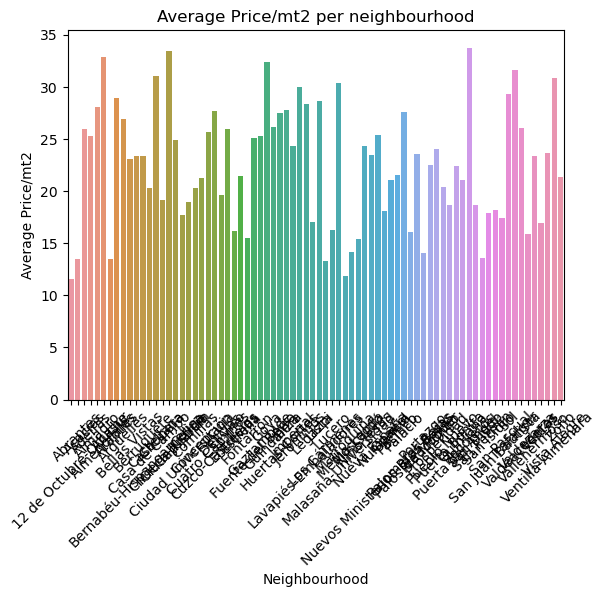

In [47]:
#plotting the average_price
sns.barplot(x='subtitle', y='price_per_size', data=average_prices_n)
plt.title('Average Price/mt2 per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price/mt2')
plt.xticks(rotation=45)
plt.show()

- Given the large number of neighbourhoods, I will be using the column "district" for the modelling part and drop "subtitle".
- The neighbourhood column "subtittle" will probably be used in the model deployment when constructing the actual rental barometer.

In [48]:
#address
display(categorical_df['address'].value_counts(dropna = False))

barrio Recoletos                    51
barrio El Viso                      45
barrio Castellana                   42
barrio Bernabéu-Hispanoamérica      38
Calle de Velázquez                  35
                                    ..
Calle de Ferraz, 54                  1
Calle Juan Bautista Sacchetti        1
Paseo de los Pontones                1
Calle de Jerónimo de la Quintana     1
Paseo de la dirección, 161           1
Name: address, Length: 2117, dtype: int64

- The address is not exact in many of the listings. Also, for the price barometer, we will be using the district and potentially neighbourhood as the key feautures for location when modelling prices (and for when users request data from the app).
- This column will therefore be dropped.

In [49]:
categorical_df = categorical_df.drop(['address'], axis=1)
categorical_df.shape

(4490, 5)

In [50]:
#title
display(categorical_df['title'].value_counts(dropna = False))

Piso                                  656
Ático                                  54
Piso en Calle de Velázquez             30
Estudio                                25
Piso en Calle de Núñez de Balboa       23
                                     ... 
Piso en Calle de San Bernardo, 118      1
Piso en trafalgar, 13                   1
Piso en Lagasca, 19                     1
Piso en Calle Conde de Aranda, 21       1
Piso en Paseo de la dirección, 161      1
Name: title, Length: 2260, dtype: int64

In [51]:
categorical_df['title'].head(60)

0                                   Piso en Madera, 7
1                          Estudio en Calle de Postas
2                                Piso en Calle Atocha
3                           Piso en Calle de la Abada
4                                                Piso
5                       Piso en Calle de Preciados, 6
6                         Piso en Calle de Esparteros
7                                                Piso
8                                  Piso en tetuan, 34
9                      Estudio en Calle Núñez de Arce
10                        Piso en Calle de la Montera
11                     Estudio en Calle de Chinchilla
12                                               Piso
13                   Ático en Carrera de San Jerónimo
14                           Piso en Calle de la Cruz
15                                               Piso
16                            Piso en Calle Coloreros
17                                               Piso
18                          

- The title is the main headline in each listing. However, the information usually refers to the property type or the address, information that is already contain in other columns.
- Will therefore drop this column for modelling.

In [52]:
categorical_df = categorical_df.drop(['title'], axis=1)
categorical_df.shape

(4490, 4)

In [53]:
#description: this is the information and description in each listing.
categorical_df['description'].head(5)

0    TuKsa Madrid Inmobiliara, ofrece en alquiler v...
1    UBK-573819 (Disponible 1-11 meses) - Sin posib...
2    *OJO DISPONIBLE A PARTIR 16 DE MAYO 2.024* Dir...
3    ALQUILER DE 1 A 12 MESES  GASTOS INCLUIDOS  Do...
4    [ESP] DISPONIBLE EN: Enero.  Reserve en línea ...
Name: description, dtype: object

- The description is different for each listing.
- However, it could be useful for extracting other features of each property, including:
    * Terrace availability: associated with words "balcón", "balcon", "balcones", "terraza", "terrace", "balcony".
    * Furniture availability: associated with words "amueblada", "amueblado", "amueblados", "amuebladas", "furniture".
- Other information, such as whether the property include monthly expenses or the type of contract, could be extracted but are less exact across listings. Will first try extracting information for these two columns.

In [54]:
#adding column "terrace": if "description" has any of these words: "balcón", "balcones", "balcon", "terraza".
categorical_df['terrace'] = categorical_df['description'].str.lower().apply(lambda x: 1 if any(word in x for word in ["balcón", "balcon", "balcones", "terraza", "terrace", "balcony"]) else 0)

In [55]:
#adding the 'terrace' column into data to be able to check with url later
data['terrace'] = categorical_df['terrace']

In [56]:
categorical_df['terrace'].value_counts(dropna = False)

0    2543
1    1947
Name: terrace, dtype: int64

In [57]:
#adding column 'furniture': if "description" has any of these words: "amueblada", "amueblado", "amueblados", "amuebladas"
categorical_df['furniture'] = categorical_df['description'].str.lower().apply(lambda x: 1 if any(word in x for word in ["amueblada", "amueblado", "amueblados", "amuebladas", "furniture"]) else 0)

In [58]:
#adding the 'furniture' column into data to be able to check with url later
data['furniture'] = categorical_df['furniture']

In [59]:
categorical_df['furniture'].value_counts(dropna = False)

1    2381
0    2109
Name: furniture, dtype: int64

In [60]:
#checking for 5 observations randomly to see if terrace = 1 corresponds to property with terrace being mentioned:
data[['description', 'url','terrace']][data['terrace']== 1].head(5)

,description,url,terrace
0,"TuKsa Madrid Inmobiliara, ofrece en alquiler v...",https://www.idealista.com/inmueble/103241997/,1.0
1,UBK-573819 (Disponible 1-11 meses) - Sin posib...,https://www.idealista.com/inmueble/101227123/,1.0
2,*OJO DISPONIBLE A PARTIR 16 DE MAYO 2.024* Dir...,https://www.idealista.com/inmueble/458306/,1.0
3,ALQUILER DE 1 A 12 MESES GASTOS INCLUIDOS Do...,https://www.idealista.com/inmueble/99586539/,1.0
7,REF: 107393 Disponible desde el 01 de Enero 20...,https://www.idealista.com/inmueble/103380788/,1.0


In [61]:
#checking for 5 observations randomly to see if terrace = 1 corresponds to property with terrace being mentioned:
data[['description', 'url','furniture']][data['furniture']== 1].tail(5)

,description,url,furniture
4491,"Hola soy Ana, ¿te gustaría vivir en el cielo d...",https://www.idealista.com/inmueble/100742210/,1.0
4492,"En una las zonas mas demandas de Madrid, con g...",https://www.idealista.com/inmueble/100844396/,1.0
4496,Piso de Home Club disponible por alquiler por ...,https://www.idealista.com/inmueble/100930829/,1.0
4497,"*Piso de 2 dormitorios con parking, ascensor, ...",https://www.idealista.com/inmueble/100097037/,1.0
4498,Piso de Home Club disponible por alquiler por ...,https://www.idealista.com/inmueble/100931418/,1.0


- For each column created, it was checked that the five properties selected did indeed include the relevant feature in the actual URL website post.
- I will therefore keep these two columns for now, but will move to the numerical_df so are included in the scaling process.
- I will also drop column "description" from categorical_df.

In [62]:
#will now move these columns to the numerical_df and drop it from categorical_df
numerical_df['terrace'] = categorical_df['terrace']
numerical_df['furniture'] = categorical_df['furniture']
categorical_df = categorical_df.drop(['terrace', 'furniture'], axis = 1)

In [63]:
#also dropping column "description" from categorical_df 
categorical_df = categorical_df.drop(['description'], axis = 1)

In [64]:
numerical_df

,price,size,rooms,bathrooms,distance,parkingSpace,hasLift,luxuryType,terrace,furniture
0,1350.0,55.0,1,2,28,0,1,0,1,1
1,1743.0,25.0,0,1,38,0,1,0,1,1
2,1595.0,98.0,2,2,81,0,1,0,1,1
3,2400.0,57.0,1,1,82,0,1,0,1,1
4,1488.0,42.0,1,1,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4495,2160.0,66.0,2,2,5692,0,1,0,0,0
4496,2160.0,55.0,1,1,5692,1,1,0,1,1
4497,2700.0,85.0,2,2,5692,0,1,0,1,1
4498,2160.0,50.0,1,1,5692,0,1,0,1,1


In [65]:
categorical_df

,propertyType,district,subtitle
0,flat,Centro,Sol
1,other,Centro,Sol
2,flat,Centro,Sol
3,flat,Centro,Sol
4,flat,Centro,Sol
...,...,...,...
4495,flat,Tetuán,Valdeacederas
4496,flat,Tetuán,Valdeacederas
4497,flat,Tetuán,Valdeacederas
4498,flat,Tetuán,Valdeacederas


In [66]:
#for location, I will keep only district for modeling
categorical_df = categorical_df.drop(['subtitle'], axis = 1)

,price,size,rooms,bathrooms,distance,parkingSpace,hasLift,luxuryType,terrace,furniture
price,1.000000,0.793285,0.571618,0.750827,-0.089668,0.254556,0.208220,0.763911,0.184292,-0.086128
size,0.793285,1.000000,0.767439,0.853806,0.061698,0.411911,0.182994,0.619754,0.208705,-0.150764
rooms,0.571618,0.767439,1.000000,0.754054,0.137313,0.306262,0.150584,0.400688,0.171713,-0.120549
bathrooms,0.750827,0.853806,0.754054,1.000000,0.050480,0.366579,0.206071,0.578612,0.183580,-0.126946
distance,-0.089668,0.061698,0.137313,0.050480,1.000000,0.232402,-0.013667,-0.037977,-0.017738,-0.016414
parkingSpace,0.254556,0.411911,0.306262,0.366579,0.232402,1.000000,0.154637,0.208240,0.105305,-0.080143
hasLift,0.208220,0.182994,0.150584,0.206071,-0.013667,0.154637,1.000000,0.095612,0.121120,0.039515
luxuryType,0.763911,0.619754,0.400688,0.578612,-0.037977,0.208240,0.095612,1.000000,0.098141,-0.083859
terrace,0.184292,0.208705,0.171713,0.183580,-0.017738,0.105305,0.121120,0.098141,1.000000,0.022085
furniture,-0.086128,-0.150764,-0.120549,-0.126946,-0.016414,-0.080143,0.039515,-0.083859,0.022085,1.000000


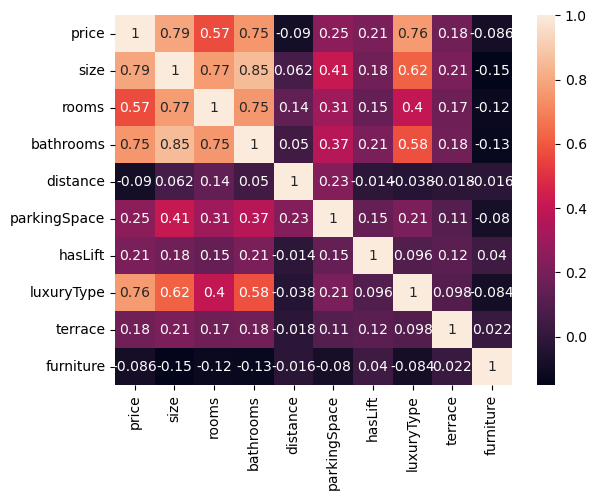

In [67]:
#checking for multicolinearity and looking at correlation with target 
correlations_matrix = numerical_df.corr()
display(correlations_matrix)
sns.heatmap(correlations_matrix, annot=True)
plt.show()

- According to the correlation heatmap, the columns "distance" and "furniture" do no seem to have almost any correlation with the target variable "price".
- I will be dropping these columns for the modelling section.
- There were also some strong correlation between certain features, however, related to the size of the property, such as between columns "rooms" and "bathrooms". I will leave all remaining columns.

In [68]:
numerical_df = numerical_df.drop(['distance', 'furniture'], axis = 1)
numerical_df

,price,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
0,1350.0,55.0,1,2,0,1,0,1
1,1743.0,25.0,0,1,0,1,0,1
2,1595.0,98.0,2,2,0,1,0,1
3,2400.0,57.0,1,1,0,1,0,1
4,1488.0,42.0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
4495,2160.0,66.0,2,2,0,1,0,0
4496,2160.0,55.0,1,1,1,1,0,1
4497,2700.0,85.0,2,2,0,1,0,1
4498,2160.0,50.0,1,1,0,1,0,1


## Processing data before modelling

In [69]:
#concatenating numerical_df & categorical_df
data_clean = pd.concat([numerical_df, categorical_df], axis=1)
data_clean

,price,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace,propertyType,district
0,1350.0,55.0,1,2,0,1,0,1,flat,Centro
1,1743.0,25.0,0,1,0,1,0,1,other,Centro
2,1595.0,98.0,2,2,0,1,0,1,flat,Centro
3,2400.0,57.0,1,1,0,1,0,1,flat,Centro
4,1488.0,42.0,1,1,0,0,0,0,flat,Centro
...,...,...,...,...,...,...,...,...,...,...
4495,2160.0,66.0,2,2,0,1,0,0,flat,Tetuán
4496,2160.0,55.0,1,1,1,1,0,1,flat,Tetuán
4497,2700.0,85.0,2,2,0,1,0,1,flat,Tetuán
4498,2160.0,50.0,1,1,0,1,0,1,flat,Tetuán


In [70]:
#rechecking no nulls
data_clean.isnull().sum()

price           0
size            0
rooms           0
bathrooms       0
parkingSpace    0
hasLift         0
luxuryType      0
terrace         0
propertyType    0
district        0
dtype: int64

In [71]:
#re-checking dtypes
data_clean.dtypes

price           float64
size            float64
rooms             int64
bathrooms         int64
parkingSpace      int64
hasLift           int64
luxuryType        int64
terrace           int64
propertyType     object
district         object
dtype: object

#### Splitting in X and Y

In [72]:
X = data_clean.drop(['price'],axis=1)
y = data_clean['price']

#### Splitting into train & test

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

#### Creating X_train_num & X_test_num

In [74]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)
X_train_num

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
3139,70.0,1,1,0,1,0,1
864,57.0,1,1,0,1,0,0
73,36.0,0,1,0,1,0,0
802,40.0,0,1,0,1,0,0
2811,160.0,3,4,0,1,1,0
...,...,...,...,...,...,...,...
3714,198.0,4,3,0,1,0,0
4483,106.0,2,2,0,1,0,1
585,243.0,3,3,1,1,1,1
163,45.0,1,2,0,1,0,0


In [75]:
X_test_num

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
944,77.0,1,1,0,1,0,0
3037,80.0,2,1,1,1,0,0
2415,66.0,1,1,1,1,0,0
737,68.0,1,1,0,1,0,1
1037,122.0,2,2,0,1,0,1
...,...,...,...,...,...,...,...
2400,128.0,3,2,0,1,0,1
2109,57.0,1,1,0,1,0,0
2836,79.0,2,1,0,1,0,1
3048,120.0,2,2,0,1,0,1


In [76]:
X_test_num

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
944,77.0,1,1,0,1,0,0
3037,80.0,2,1,1,1,0,0
2415,66.0,1,1,1,1,0,0
737,68.0,1,1,0,1,0,1
1037,122.0,2,2,0,1,0,1
...,...,...,...,...,...,...,...
2400,128.0,3,2,0,1,0,1
2109,57.0,1,1,0,1,0,0
2836,79.0,2,1,0,1,0,1
3048,120.0,2,2,0,1,0,1


#### Scaling X_train_num

In [77]:
MinMaxtransformer = MinMaxScaler().fit(X_train_num)
x_standardized = MinMaxtransformer.transform(X_train_num)
print(x_standardized.shape)
X_train_num_s = pd.DataFrame(x_standardized, columns=X_train_num.columns)
X_train_num_s

(3592, 7)


,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
0,0.090909,0.125,0.000000,0.0,1.0,0.0,1.0
1,0.068611,0.125,0.000000,0.0,1.0,0.0,0.0
2,0.032590,0.000,0.000000,0.0,1.0,0.0,0.0
3,0.039451,0.000,0.000000,0.0,1.0,0.0,0.0
4,0.245283,0.375,0.428571,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
3587,0.310463,0.500,0.285714,0.0,1.0,0.0,0.0
3588,0.152659,0.250,0.142857,0.0,1.0,0.0,1.0
3589,0.387650,0.375,0.285714,1.0,1.0,1.0,1.0
3590,0.048027,0.125,0.142857,0.0,1.0,0.0,0.0


In [79]:
#saving scaler in pickle to be used in separate notebook
import pickle
pickle.dump(MinMaxtransformer, open('scaler.pkl', 'wb'))

#### Using trained scaler to scale X_test_num

In [78]:
x_standardized = MinMaxtransformer.transform(X_test_num)
print(x_standardized.shape)
X_test_num_s = pd.DataFrame(x_standardized, columns=X_test_num.columns)
X_test_num_s

(898, 7)


,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
0,0.102916,0.125,0.000000,0.0,1.0,0.0,0.0
1,0.108062,0.250,0.000000,1.0,1.0,0.0,0.0
2,0.084048,0.125,0.000000,1.0,1.0,0.0,0.0
3,0.087479,0.125,0.000000,0.0,1.0,0.0,1.0
4,0.180103,0.250,0.142857,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
893,0.190395,0.375,0.142857,0.0,1.0,0.0,1.0
894,0.068611,0.125,0.000000,0.0,1.0,0.0,0.0
895,0.106346,0.250,0.000000,0.0,1.0,0.0,1.0
896,0.176672,0.250,0.142857,0.0,1.0,0.0,1.0


#### Creating X_train_cat & X_test_cat

In [79]:
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)
X_train_cat

,propertyType,district
3139,flat,Chamberí
864,flat,Moncloa-Arganzuela
73,other,Centro
802,penthouse,Centro
2811,flat,Barrio de Salamanca
...,...,...
3714,flat,Tetuán
4483,flat,Vallecas-Ciudad Lineal
585,flat,Centro
163,flat,Centro


In [80]:
X_test_cat

,propertyType,district
944,flat,Centro
3037,flat,Barrio de Salamanca
2415,flat,Barrio de Salamanca
737,penthouse,Centro
1037,flat,Moncloa-Arganzuela
...,...,...
2400,flat,Retiro
2109,flat,Distritos Sur
2836,flat,Distritos Sur
3048,penthouse,Barrio de Salamanca


#### One-hot encoding X_train_cat

In [81]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
encoded = encoder.transform(X_train_cat).toarray()
X_train_cat_onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_train_cat_onehot_encoded 

,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
#saving encoder in pickle
import pickle
pickle.dump(encoder, open('encoder.pkl', 'wb'))

#### One-hot encoding X_test_cat

In [82]:
encoded = encoder.transform(X_test_cat).toarray()
X_test_cat_onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_test_cat_onehot_encoded 

,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
894,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
895,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Concatenating X_train from X_train_num_s & X_train_cat_onehot_encoded

In [83]:
X_train = pd.concat([X_train_num_s, X_train_cat_onehot_encoded], axis=1)
display(X_train.dtypes)
X_train

size                               float64
rooms                              float64
bathrooms                          float64
parkingSpace                       float64
hasLift                            float64
luxuryType                         float64
terrace                            float64
propertyType_other                 float64
propertyType_penthouse             float64
district_Centro                    float64
district_Chamartín                 float64
district_Chamberí                  float64
district_Distritos Sur             float64
district_Moncloa-Arganzuela        float64
district_Retiro                    float64
district_Tetuán                    float64
district_Vallecas-Ciudad Lineal    float64
dtype: object

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.090909,0.125,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.068611,0.125,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.032590,0.000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.039451,0.000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.245283,0.375,0.428571,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,0.310463,0.500,0.285714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3588,0.152659,0.250,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3589,0.387650,0.375,0.285714,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3590,0.048027,0.125,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Repeating for X_Test

In [84]:
X_test = pd.concat([X_test_num_s, X_test_cat_onehot_encoded], axis=1)
display(X_test.dtypes)
X_test

size                               float64
rooms                              float64
bathrooms                          float64
parkingSpace                       float64
hasLift                            float64
luxuryType                         float64
terrace                            float64
propertyType_other                 float64
propertyType_penthouse             float64
district_Centro                    float64
district_Chamartín                 float64
district_Chamberí                  float64
district_Distritos Sur             float64
district_Moncloa-Arganzuela        float64
district_Retiro                    float64
district_Tetuán                    float64
district_Vallecas-Ciudad Lineal    float64
dtype: object

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.102916,0.125,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.108062,0.250,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.084048,0.125,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.087479,0.125,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.180103,0.250,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,0.190395,0.375,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
894,0.068611,0.125,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
895,0.106346,0.250,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
896,0.176672,0.250,0.142857,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

- For this section, we will first build a function for creating models using different algorithms.
- The models will then be evaluated based on the accuracy both in the train and, most importantly, in the test sample.
- After choosing the family of models that best fits with this data, we will be conducting parameter optimization to improve the quality of the model.
- A final model specification will finally be selected. The model will be fitted using all dataset (not only the train data) and saved to be used as predictor in the rental barometer interface.

#### Defining a function to run all models

In [85]:
def models_automation(models, X_tr, y_tr,X_te, y_te):
    R_score_train = []
    R_score_test = []
    RMSE = []
    for model in models:
        model.fit(X_tr, y_tr)
        mse = mean_squared_error(y_te,model.predict(X_te))  
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}, RMSE -> {math.sqrt(mse)}")
        R_score_train.append(model.score(X_tr, y_tr))
        R_score_test.append(model.score(X_te, y_te))
    column_names=["R_score_train","R_score_test"]
    results = pd.DataFrame({'R_score_train': R_score_train, 'R_score_test': R_score_test})
    return results

#### Running models

In [86]:
model_list = [LinearRegression(),SGDRegressor(),KNeighborsRegressor(), MLPRegressor(),DecisionTreeRegressor(),RandomForestRegressor()]
results = models_automation(model_list, X_train, y_train,X_test, y_test)

LinearRegression: Train -> 0.7913449117409583, Test -> 0.7701751958678758, RMSE -> 943.8540905104078
SGDRegressor: Train -> 0.786977167343839, Test -> 0.7794965204546366, RMSE -> 924.5153717805877
KNeighborsRegressor: Train -> 0.8505841388044085, Test -> 0.7961369622404798, RMSE -> 888.9465702288319


/Users/antoniomontilla/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor: Train -> 0.4225488942932316, Test -> 0.467451487709292, RMSE -> 1436.7658633690787
DecisionTreeRegressor: Train -> 0.9845702242759983, Test -> 0.6437103659921976, RMSE -> 1175.1897814763033
RandomForestRegressor: Train -> 0.9614728362319288, Test -> 0.7923329872667536, RMSE -> 897.2018715163501


In [87]:
results['Model'] = model_list
results['Model'] = results['Model'].astype(str).str.split('(').str[0]
display(results.dtypes)
results

R_score_train    float64
R_score_test     float64
Model             object
dtype: object

,R_score_train,R_score_test,Model
0,0.791345,0.770175,LinearRegression
1,0.786977,0.779497,SGDRegressor
2,0.850584,0.796137,KNeighborsRegressor
3,0.422549,0.467451,MLPRegressor
4,0.984570,0.643710,DecisionTreeRegressor
5,0.961473,0.792333,RandomForestRegressor


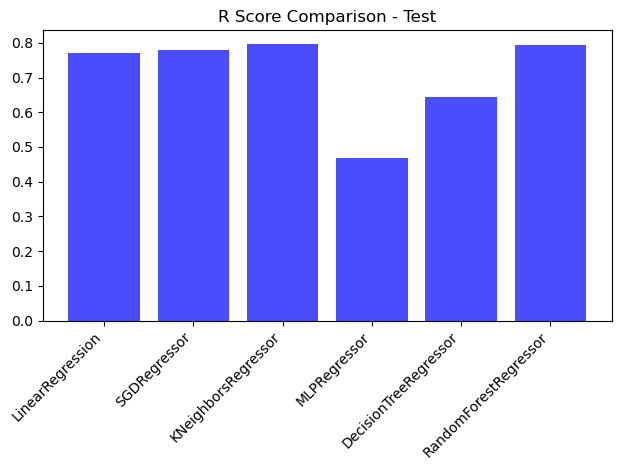

In [88]:
# Plotting R_score_test
plt.bar(results['Model'], results['R_score_test'], color='blue', alpha=0.7, label='R_score_test')
plt.title('R Score Comparison - Test')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

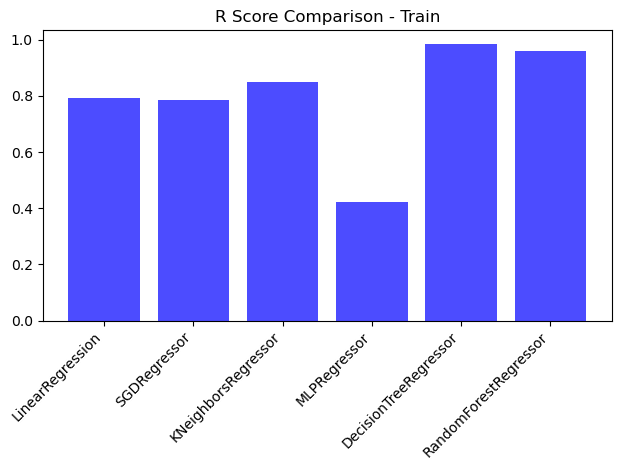

In [89]:
# Plotting R_score_train
plt.bar(results['Model'], results['R_score_train'], color='blue', alpha=0.7, label='R_score_train')
plt.title('R Score Comparison - Train')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

#### Modelling observations:
- Based on the model results, the two algorithms that best fit to the data, in both the training and the test set, are the Random Forest Regressor and KNeighborsRegressor.
- The Random Forest algorithm, however, is known for its deterministic qualities. I will therefore run cross validation techniques to validate the accuracy performance of this model and compare it with KNeighborsRegressor.
- Afterwards, I will perform hyperparameter search to best select the parameters to be used in the model.

#### Cross validation: RandomForestRegressor versus KNeighborsRegressor

In [90]:
model1 = RandomForestRegressor()
model2 = KNeighborsRegressor()
model_pipeline = [model1, model2]
model_names = ['RandomForestRegressor', 'KNeighborsRegressor']
scores = {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    scores[model_name] = mean_score
print(scores)

{'RandomForestRegressor': 0.7902610107591186, 'KNeighborsRegressor': 0.7625656084710798}


In [91]:
#scores based on the test data
val_scores = {}
for model, model_name in zip(model_pipeline,model_names):
    model.fit(X_train, y_train)
    val_scores[model_name] = model.score(X_test,y_test)
print(val_scores)

{'RandomForestRegressor': 0.7843920740805802, 'KNeighborsRegressor': 0.7961369622404798}


- 'RandomForestRegressor' seems to be the best model for fitting this data.
- I will conduct hyperparameter search to improve the quality of the model.

### Hyperparameter search

In [115]:
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [3, 10, None],
    'criterion': ['squared_error', 'absolute_error'],  # Mean Squared Error or Mean Absolute Error
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10]
}

model = RandomForestRegressor()

# Creating GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [116]:
# Fitting the model to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [3, 10, None],
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [10, 50, 100]})

In [117]:
#printing the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.799901766129713


In [92]:
#building a model with these parameters
# Best parameters from GridSearchCV outcome
best_params = {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=2)

In [93]:
#Test evaluation
print(best_model.score(X_test, y_test))
#Train evaluation
print(best_model.score(X_train, y_train))

0.8010841783659236
0.8822486579019431


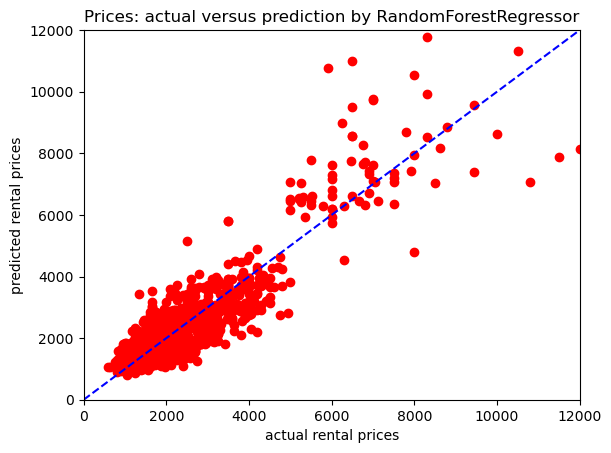

In [101]:
#plotting predictions versus y_test
predictions = best_model.predict(X_test)
plt.figure()
plt.scatter(y_test,predictions, marker = 'o', color='red')
plt.xlabel('actual rental prices')
plt.ylabel('predicted rental prices')
plt.title('Prices: actual versus prediction by RandomForestRegressor')

#setting axis limits (to exclude outliers for visualization)
plt.xlim(0, 12000)
plt.ylim(0, 12000)

#adding a diagonal line
plt.plot([0, 12000], [0, 12000], color='blue', linestyle='--')


plt.show()

### Final step: building the RandomForestRegressor using all of the available data

In [94]:
X

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace,propertyType,district
0,55.0,1,2,0,1,0,1,flat,Centro
1,25.0,0,1,0,1,0,1,other,Centro
2,98.0,2,2,0,1,0,1,flat,Centro
3,57.0,1,1,0,1,0,1,flat,Centro
4,42.0,1,1,0,0,0,0,flat,Centro
...,...,...,...,...,...,...,...,...,...
4495,66.0,2,2,0,1,0,0,flat,Tetuán
4496,55.0,1,1,1,1,0,1,flat,Tetuán
4497,85.0,2,2,0,1,0,1,flat,Tetuán
4498,50.0,1,1,0,1,0,1,flat,Tetuán


In [95]:
#Creating X_num & scaling
X_num = X.select_dtypes(np.number)
x_num_standardized = MinMaxtransformer.transform(X_num)
X_num_s = pd.DataFrame(x_num_standardized, columns=X_num.columns)
X_num_s

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace
0,0.065180,0.125,0.142857,0.0,1.0,0.0,1.0
1,0.013722,0.000,0.000000,0.0,1.0,0.0,1.0
2,0.138937,0.250,0.142857,0.0,1.0,0.0,1.0
3,0.068611,0.125,0.000000,0.0,1.0,0.0,1.0
4,0.042882,0.125,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4485,0.084048,0.250,0.142857,0.0,1.0,0.0,0.0
4486,0.065180,0.125,0.000000,1.0,1.0,0.0,1.0
4487,0.116638,0.250,0.142857,0.0,1.0,0.0,1.0
4488,0.056604,0.125,0.000000,0.0,1.0,0.0,1.0


In [96]:
#Creating X_cat & encoding
X_cat = X.select_dtypes(object)
encoded = encoder.transform(X_cat).toarray()
X_cat_onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_cat_onehot_encoded

,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [97]:
#Concatenating X_all
X_all = pd.concat([X_num_s, X_cat_onehot_encoded], axis=1)
display(X_all.dtypes)
X_all

size                               float64
rooms                              float64
bathrooms                          float64
parkingSpace                       float64
hasLift                            float64
luxuryType                         float64
terrace                            float64
propertyType_other                 float64
propertyType_penthouse             float64
district_Centro                    float64
district_Chamartín                 float64
district_Chamberí                  float64
district_Distritos Sur             float64
district_Moncloa-Arganzuela        float64
district_Retiro                    float64
district_Tetuán                    float64
district_Vallecas-Ciudad Lineal    float64
dtype: object

,size,rooms,bathrooms,parkingSpace,hasLift,luxuryType,terrace,propertyType_other,propertyType_penthouse,district_Centro,district_Chamartín,district_Chamberí,district_Distritos Sur,district_Moncloa-Arganzuela,district_Retiro,district_Tetuán,district_Vallecas-Ciudad Lineal
0,0.065180,0.125,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.013722,0.000,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.138937,0.250,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.068611,0.125,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.042882,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,0.084048,0.250,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4486,0.065180,0.125,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4487,0.116638,0.250,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4488,0.056604,0.125,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [98]:
#Creating the final model
best_params = {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_all, y)
print(final_model.score(X_all, y))

0.8819744114666647


In [99]:
#saving model in pickle to be used in separate notebook
pickle.dump(final_model, open('final_model.pkl', 'wb'))

## Final remarks and following steps

- The final RandomForestRegressor recorded a R2 score of 0.8 in the test set and 0.9 in the train set data, making it the best model for fitting the rental price database.
- This model will be used in the following steps to calculate predictions of rental prices based on selected features given by user in the rental barometer's interface.
- The interface will also show actual rental price statistics (average, minimum and maximum) of available properties matching the criteria. It will also provide a list of 5 potential properties.
-  As a final step, the interface will give the user an option to retrieve socio-economic data for the enquired district.

### Further steps continue in a separate notebook: Rental_price_barometer3_deployment